In [232]:
from textblob import TextBlob, Sentence
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import os

import pygal
from pygal.style import Style
from IPython.display import display, HTML

%matplotlib inline

# Master of None Sentiment Analysis

Things I have wanted to do for a while and finally found time to do:
- rewatch Master of None
- play around with some natural language processing (NLP)

Things I also did:
- natural language processing with Master of None scripts

The episode scripts used for this analysis were scraped from [Springfield! Springfield! Movie & TV Show Scripts](https://www.springfieldspringfield.co.uk/) using *download-scripts.py*, which can be found in this repo.

## Thanksgiving!

Gonna start with my one of my favorites, the Thanksgiving episode in season 2.

In [233]:
episode_dir = './master-of-none'
episode_name = 's02e08-Thanksgiving.txt'
with open("{}/{}".format(episode_dir, episode_name), 'r') as f:
    s2e8_text = f.read()

In [234]:
s2e8_text[:1000]

"1\n  [Bob Barker] The first\n Showcase Showdown.\n  On its way, ladies and gentlemen.\n  It is round and around and around\n that it goes.\n  [cheers and applause on TV]\n  Where Denise at?\n  She upstairs with her little boyfriend.\n  [laughing] Oh, wait.\n Denise got a little boyfriend?\n  - Mm-hmm.\n - [laughs]\n  [cheers and applause on TV]\n  Y'all better stop running\n through this house.\n  [Denise] Yes, Grandma.\n  Denise, what were y'all doing up there?\n  Watching Fresh Prince.\n  You weren't eating candy, were you?\n  No.\n  Dev, do y'all even celebrate\n Thanksgiving in your house?\n  Is that a thing y'all do\n in the Indian community?\n  We have lunch together.\n  Then my dad watches The Godfather\n and falls asleep.\n  [laughs]\n  Well, you are welcome to come have\n  Thanksgiving with us anytime you want.\n  What's the Indian community?\n  [laughs]\n  Dev is Indian.\n  Wait. I thought Dev was black.\n  - I'm brown.\n - Black people are brown, too.\n  [Catherine] Oh, Lor

We've got some things that aren't part of the dialogue here: names like [Denise] and [Catherine], and actions like [laughs] and [cheers and applause on TV]. While the latter can give some context to the mood of the scene, I'm making an executive decision here to remove them since I want to limit my analysis to the script dialogue.

In [235]:
def clean_text(text):
    """
    Return text with special characters and non-dialogue (e.g. [laughs], [Denise]) removed.
    Params:
        text: string
    """
    text = re.sub(r'^1\s*', '', text) # scraped scripts start with 1
    dialogue = re.sub(r'\[.*\]', '', text)
    return re.sub('[^A-Za-z0-9\'?!. ]+', '', dialogue)

In [236]:
s2e8_cleaned_text = clean_text(thanks_text)

When I analyze word usage frequency, I want to exclude common stopwords without an particular significance like "the" and "and". Just gonna leave this here for now.

In [237]:
def remove_stop_words(text):
    """
    Return text with stopwords removed.
    Note that this removes punctuation like (!?.,) as well.
    Params:
        text: string
    """
    stop_words = stopwords.words('english')
    blob = TextBlob(text)
    words = [word for word in blob.words if word not in stop_words]
    return ' '.join(words)

A look at what we've got now:

In [238]:
s2e8_cleaned_text[:1000]

" The first Showcase Showdown.  On its way ladies and gentlemen.  It is round and around and around that it goes.    Where Denise at?  She upstairs with her little boyfriend.   Oh wait. Denise got a little boyfriend?   Mmhmm.      Y'all better stop running through this house.   Yes Grandma.  Denise what were y'all doing up there?  Watching Fresh Prince.  You weren't eating candy were you?  No.  Dev do y'all even celebrate Thanksgiving in your house?  Is that a thing y'all do in the Indian community?  We have lunch together.  Then my dad watches The Godfather and falls asleep.    Well you are welcome to come have  Thanksgiving with us anytime you want.  What's the Indian community?    Dev is Indian.  Wait. I thought Dev was black.   I'm brown.  Black people are brown too.   Oh Lord.  Okay.  Look both of you are minorities.  What's a minority?  It's a group of people who have to work  twice as hard in life to get half as far  and Denise you a black woman  so you gonna have to work three 

In [239]:
s2e8_blob = TextBlob(s2e8_cleaned_text)

### Overall sentiment of entire episode:

In [240]:
s2e8_blob.sentiment

Sentiment(polarity=0.12602021893037516, subjectivity=0.5488213854382333)

The overall polarity of this episode was 0.126 ( > 0), so it's not particularly positive but still more positive than it is negative.

In [241]:
def get_sentence_polarities(blob):
    """
    Return dictionary with {sentence (string): polarity} for sentences in blob.
    Params:
        blob: TextBlob
    """
    sentence_polarities = {}

    for sent in blob.sentences:
        polarity = sent.sentiment.polarity
        sentence_polarities[str(sent)] = polarity
        
    return sentence_polarities

In [242]:
s2e8_sentence_polarities = get_sentence_polarities(s2e8_blob)

Cool, now I have a dictionary mapping sentences to their respective polarities. I'm gonna load all of that into a dataframe now and see what we can find.

In [243]:
s2e8_sentence_df = pd.DataFrame(list(s2e8_sentence_polarities.items()),
                                columns=['sentence', 'polarity'])

In [244]:
s2e8_sentence_df.tail()

,sentence,polarity
619,Go ahead.,0.0
620,So Grandma when we were teenagers we used to ...,0.0
621,Oh yeah I remember that.,0.0
622,The whole house smelled like reefer.,0.2
623,Can we say grace?,0.0


I wanna play around with visualizing sentiment over the course of the episode, but one thing that doesn't come with the scripts is timestamps. So instead of plotting sentiment over time (e.g., how many minutes into the episode), I'm gonna assign each sentence a 'relative' position - how far into the script it is. 

For instance, in this script with 623 sentences, the first sentence would be at 1/623 = .0016 (.16% far along into the script), the 312th sentence would be at about the 50% mark, and the 623rd episode would be at 1 (100% along into the script.)

In [245]:
s2e8_sentence_df['relative_position'] = s2e8_sentence_df.index / len(s2e8_sentence_df)

In [246]:
s2e8_sentence_df.tail()

,sentence,polarity,relative_position
619,Go ahead.,0.0,0.991987
620,So Grandma when we were teenagers we used to ...,0.0,0.993590
621,Oh yeah I remember that.,0.0,0.995192
622,The whole house smelled like reefer.,0.2,0.996795
623,Can we say grace?,0.0,0.998397


## Plotting sentiment over the course of the episode

In [247]:
# set matplotlib parameters
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

plt.style.use('seaborn-white')

blue_gradient = ['#456B83','#48768F','#4A829B','#4B8FA6','#4C9BB1',
             '#4DA8BC','#4DB5C7','#4DC2D1','#4DCFDB','#4EDDE4'] # blue gradient
red_gradient = ['#BA6370','#C26772','#CA6B73','#D16F74','#D97375',
             '#E07776','#E87C77','#EF8077','#F68578','#FD8A78'] # red gradient
colors = ['#556270', '#4ECDC4', '#B4D869', '#FF6B6B', '#C44D58',
          '#FF895D', '#EC9F39', '#197171', '#4087CE', '#624464'] # different colors

In [248]:
def create_plot(figsize=(15,6), title="", xlabel="", ylabel="", fig=None, ax=None, episode=False):
    """
    Create matplotlib plot with provided parameters. Returns fig, ax.
    If fig & ax are provided, changes will be applied to them instead of creating a 
        new plot.
    If the plot is for an episode, the appropriate xticks & labels will be applied.
    """
    if fig == None and ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if episode:
        xtick_labels = np.array([0, 0.25, 0.50, 0.75, 1.0])
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xticklabels(xtick_labels)

        ax.axhline(0, color='#D3D3D3', zorder=1, lw=0.5)
        ax.set_ylim(-1, 1)
        ax.set_xlim(0, 1)
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.spines['left'].set_color('#D3D3D3')

                
    return fig, ax

Let's start with something simple - a line plot.

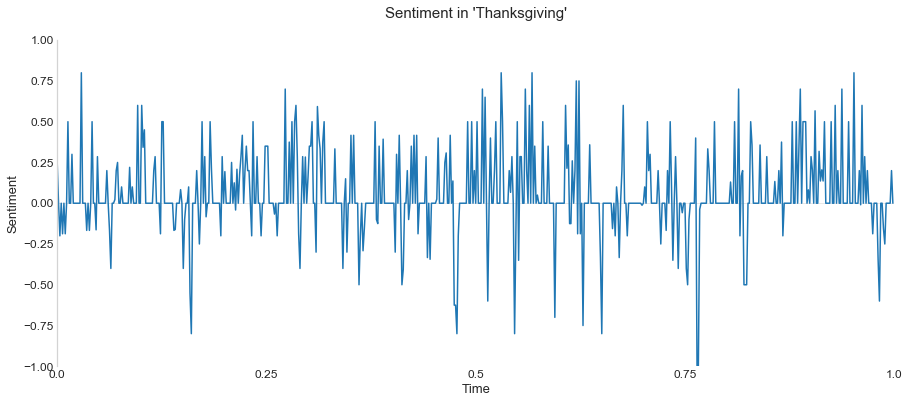

In [249]:
fig, ax = create_plot(title="Sentiment in 'Thanksgiving'\n", xlabel="Time",
                      ylabel="Sentiment", episode=True)

ax.plot(s2e8_sentence_df['relative_position'], s2e8_sentence_df['polarity'], lw=1.5)

plt.show()

There's a *lot* of detail here, since I've plotted the sentiments of every single sentence in the episode (and there are 602 sentences) - so it's hard to see the overall trends over the episode.

Instead of plotting the sentiment over every single sentence, I'm gonna look at the average sentiments over 'windows' of N sentences. I'll start with a default window of 3 sentences, but we can play around with that later.

In [250]:
def average_over_window(df, size=3):
    """
    Average polarities of a dataframe over a 'window' of n sentences. 
    Return dataframe columns ['polarity', 'relative_position'].
    Params:
        df: dataframe with 'polarity' column
        size: size of window
    """
    index = 0
    polarities = []
    
    while(index + size < len(df)):
        window = df[index:index+size]
        polarity = window['polarity'].mean()
        polarities.append(polarity)
        index += size
        
    averaged_polarities = pd.DataFrame({'polarity': polarities})
    averaged_polarities['relative_position'] = averaged_polarities.index / len(averaged_polarities)
    
    return averaged_polarities

In [251]:
s2e8_averaged_polarities = average_over_window(s2e8_sentence_df)

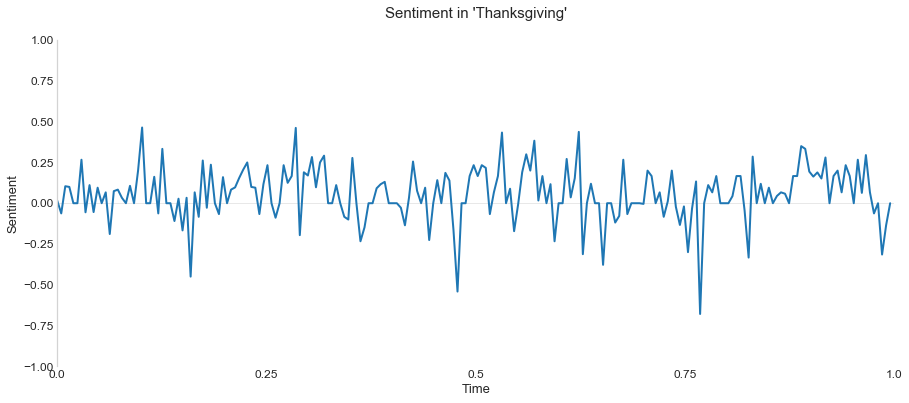

In [252]:
fig, ax = create_plot(title="Sentiment in 'Thanksgiving'\n", xlabel="Time",
                      ylabel="Sentiment", episode=True)

ax.plot(s2e8_averaged_polarities['relative_position'], 
        s2e8_averaged_polarities['polarity'],lw=2)

plt.show()

That's a lot better. One thing to note is that we do lose some detail by averaging over windows, though. For instance, in the first graph where every single sentence is plotted, we can see the points where some really negative sentences are said (e.g. a sentence with a polarity of -1 around the 0.75 time mark). Since I'm now taking the averages over windows, we don't see such extreme values anymore.

Coding the sentences by color will also help convey information about sentiment. I'm gonna plot the sentiment of each sentence as a bar graph, where sentences with positive sentiment will be blue and sentences with negative sentiment will be red. I'm also gonna use color gradients, where the more 'extreme' a value is (ie, closer to -1 or 1), the darker it's bar will be.

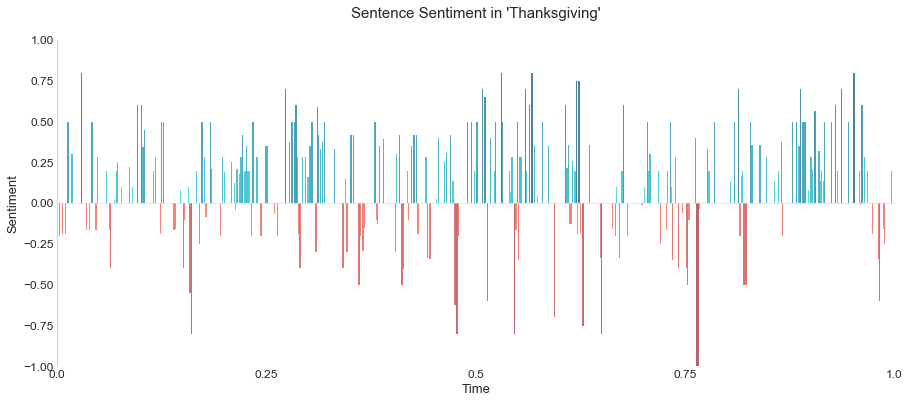

In [253]:
fig, ax = create_plot(figsize=(15, 6), title="Sentence Sentiment in 'Thanksgiving'\n", xlabel='Time',
                      ylabel='Sentiment', episode=True)

# create color gradient bins
sent_colors = pd.cut(s2e8_sentence_df['polarity'], 
                          np.linspace(-1, 1, num=21, endpoint=True), include_lowest=True,
                          labels=red_gradient + blue_gradient[::-1])

ax.bar(s2e8_sentence_df['relative_position'], s2e8_sentence_df['polarity'], 
       color=sent_colors, width=.9/len(s2e8_sentence_df))

plt.show()

I've plotted all 602 sentences here, it's easier to understand than the original line graph with all 602 sentences. There's also a lot more detail retained - you can see the points where really negalive sentences (sentiment of -1) were said. 

And with the sentiments 'averaged' over windows of 3 sentences:

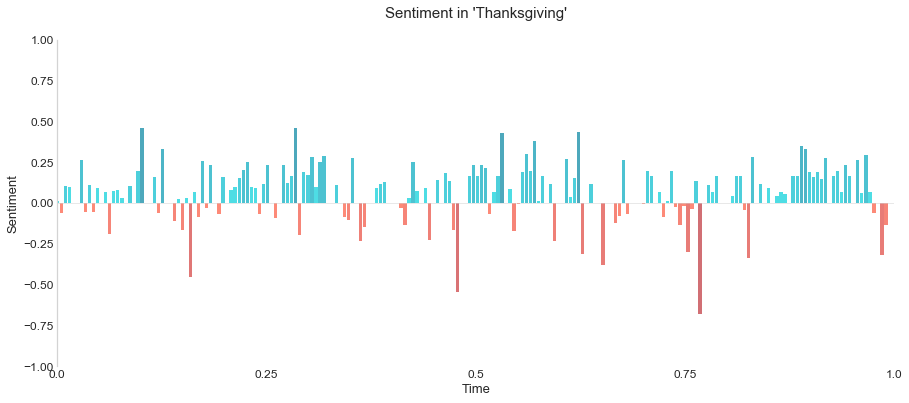

In [254]:
fig, ax = create_plot(title="Sentiment in 'Thanksgiving'\n", xlabel='Time',
                      ylabel='Sentiment', episode=True)

sent_colors = pd.cut(s2e8_averaged_polarities['polarity'], 
                     np.linspace(-1, 1, num=21, endpoint=True), 
                     include_lowest=True, labels=red_gradient + blue_gradient[::-1])

ax.bar(s2e8_averaged_polarities['relative_position'], s2e8_averaged_polarities['polarity'], 
       color=sent_colors, width=0.8/len(s2e8_averaged_polarities));

ax.set_ylim(-1, 1)

plt.show()

### Top 10 Positive Sentences

In [255]:
s2e8_sorted_sentences = s2e8_sentence_df.sort_values(by=['polarity'], ascending=False)

In [256]:
print('Sentence|Polarity')
for index, row, in s2e8_sorted_sentences[:10].iterrows():
    polarity = round(row['polarity'], 3)
    print('{}|{}'.format(row['sentence'], polarity))

Sentence|Polarity
I'm happy for you.|0.8
They're great.|0.8
Welcome darling.|0.8
Well you are welcome to come have  Thanksgiving with us anytime you want.|0.8
I said your yams turned out really nice this year!|0.75
Grandma Ernestine your yams turned out really nice this year!|0.75
That's good to know.|0.7
Yeah man it's really good.|0.7
It's so great to  Nice to meet you.|0.7
They good?|0.7


### Top 10 Negative Sentences

In [257]:
print('Sentence|Polarity')
for index, row, in s2e8_sorted_sentences[::-1][:10].iterrows():
    polarity = round(row['polarity'], 3)
    print('{}|{}'.format(row['sentence'], polarity))

Sentence|Polarity
Horrible.|-1.0
That's horrible.|-1.0
Damn why you got to hate on the Pan?|-0.8
That character was an idiot.|-0.8
Stupid.|-0.8
seventeenfoot aluminum boat that broke apart    Man I told you this is stupid.|-0.8
Don't you ask another fucking question!|-0.75
Well you know my hearing is bad.|-0.7
Why would they be mad?|-0.625
I feel like all three of them are gonna be mad at you about that.|-0.625


*I said your yams turned out really nice this year!*

## Visualizing Scenes

I spent a lot of time thinking about how to display the progression of sentiment in a scene along with sentences. I ended up going with an interactive line chart to avoid clutter. You still get to see the ups-and-downs in emotion as the scene progresses, but you can also hover over points in the line graph to see the sentence associated with each sentiment. (Also, it gave me an excuse to mess around with pygal!)

*Note: won't display interactively on github. Will work when run in jupyter notebook or on [nbviewer](https://nbviewer.jupyter.org/github/ashleyshine/feels/blob/master/Master-of-None.ipynb?flush_cache=true)
But, for the sake of not breaking things here (and by here, I mean on github) - I'm gonna leave the interactive line graphs at the end of this notebook. I've just included the non-interactive images of the graphs here. If you scroll down that far, fun things are ahead!*

In [258]:
# use for inline display of interactive plots
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def inline_display(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))
    
custom_style = Style(
    background = '#ffffff', # image background 
    tooltip_font_size = 18
)

In [259]:
line_chart1 = pygal.Line(width=800, height=300, dots_size=3, show_legend=False, 
                        interpolate='cubic', style=custom_style, show_x_labels=False,
                        title="Yams Scene in s02e08 'Thanksgiving'")

line_chart1.y_labels = [-1, -0.5, 0, 0.5, 1.0]
line_chart1.x_labels = s2e8_sentence_df[319:400]['sentence']
line_chart1.add('Sentence', s2e8_sentence_df[319:400]['polarity'])

# inline_display(line_chart1)
line_chart1.render_to_file('./img/chart1.svg')

![chart1](https://rawgit.com/ashleyshine/feels/master/img/chart1.svg)

### And some other fun scenes:

Dev and Arnold get their car stuck driving in an alley in Italy. Dev (being super helpful) climbs out and take a photo. 

Fun fact: [this actually happened](https://www.buzzfeed.com/scottybryan/master-of-none-season-two-episode-two?utm_term=.utZwX73NB#.ojM9Ex24j)

In [260]:
episode='s02e02-Le-Nozze.txt'
with open('{}/{}'.format(episode_dir, episode), 'r') as f:
    text = f.read()
    
cleaned_text = clean_text(text)
blob = TextBlob(cleaned_text)
sentence_polarities = get_sentence_polarities(blob)
s2e2_sentence_df = create_sentence_df(sentence_polarities)

line_chart3 = pygal.Line(width=800, height=300, dots_size=3, show_legend=False, 
                        interpolate='cubic', style=custom_style, show_x_labels=False,
                        title="Dev-And-Arnold-Get-Stuck-Between-Walls Scene in s02e02 'Le Nozze'")

line_chart3.y_labels = [-1, -0.5, 0, 0.5, 1.0]
line_chart3.x_labels = s2e2_sentence_df[200:275]['sentence']
line_chart3.add('Sentence', s2e2_sentence_df[200:275]['polarity'])

# inline_display(line_chart3)
line_chart3.render_to_file('./img/chart3.svg')

![chart3](https://rawgit.com/ashleyshine/feels/master/img/chart3.svg)

One of my favorite scenes is when Francesca (being Italian) absolutely freaks out when she and Dev come across an American pharmacy. It has everything! 20 kinds of toothpaste, tiny Vaseline, and *chocolate diarrhea medicine*. As she tells, Dev, *this is an amazing time to be alive.* 

In [261]:
episode='s02e09-Amarsi-Un-Po.txt'
with open('{}/{}'.format(episode_dir, episode), 'r') as f:
    text = f.read()
    
cleaned_text = clean_text(text)
blob = TextBlob(cleaned_text)
episode_polarity = blob.sentiment.polarity
sentence_polarities = get_sentence_polarities(blob)
s2e9_sentence_df = create_sentence_df(sentence_polarities)

line_chart2 = pygal.Line(width=800, height=300, dots_size=3, show_legend=False, 
                        interpolate='cubic', style=custom_style, show_x_labels=False,
                        title="Pharmacy Scene in s02e09 'Amarsi Un Po'")

line_chart2.y_labels = [-1, -0.5, 0, 0.5, 1.0]
line_chart2.x_labels = s2e9_sentence_df[152:195]['sentence']
line_chart2.add('Sentence', s2e9_sentence_df[152:195]['polarity'])

# inline_display(line_chart2)
line_chart2.render_to_file('./img/chart2.svg')

![chart2](https://rawgit.com/ashleyshine/feels/master/img/chart2.svg)

Let's take a look at the some of the most positive & negative sentences in the episode!

## Oh, how the seasons change...

Okay! Now let's look at seasons 1 and 2 as a whole. 

I've got all the scripts for both season 1 and 2, but I wanna look at season 1 first.

In [262]:
def get_season_episodes(directory, season):
    """
    Return list of episode files for a given season.
    Params:
        directory: string path to directory with script files
        season: int
    """
    if season < 10:
        season_str = '0{}'.format(season) # single digit seasons are preceded by a 0
    else:
        season_str = str(season)
        
    episodes = []
    for file in os.listdir(directory):
        regex_str = r'^s{}.*'.format(season_str)
        mo = re.search(regex_str, file, re.IGNORECASE)
        if mo:
            episode = mo.group()
            episodes.append(episode)
    
    return episodes

In [263]:
def get_episode_title(text, episode_info=False):
    """
    Return string with episode title, and season/episode info if requested.
    Params:
        text: string
        episode_info: True to include season/episode info.
    """
    if episode_info:
        title = text.replace('-', ' ').replace('.txt', '')
    else:
        regex_str = r's\d+e\d+(.*)'
        mo = re.search(regex_str, text, re.IGNORECASE)
        title = mo.group(1)
    return title

Gonna write a function to create the dataframe of with sentence, polarity, & relative position from the dictionary of sentences & polarities.

In [264]:
def create_sentence_df(sentence_polarities, window=1):
    """
    Return dataframe with columns ['sentence', 'polarity', 'relative_position'].
    Params:
        sentence_polarities: dictionary with {sentence: polarity}
    """
    sentence_df = pd.DataFrame(list(sentence_polarities.items()),
                               columns=['sentence', 'polarity'])
    sentence_df['relative_position'] = sentence_df.index / len(sentence_df)

    return sentence_df

For the curious (aka me), I'm gonna write the top 10 positive & negative sentences in each episode to a file to avoid clutter here. Peep 'Master-of-None-sentences.txt'.

In [265]:
def write_top_sentences(f, sentence_df, title):
    """
    Write the top 10 positive & negative sentences to file.
    Params:
        f: file to write to
        sentence_df: dataframe with sentences & polarities
        title: string
    """
    sorted_sentences = sentence_df.sort_values(by=['polarity'], ascending=False)
    f.write(str('********** {} **********\n'.format(title)))
        
    f.write('\n***** Top 10 Positive Sentences *****\n')
    f.write('Sentence|Polarity\n')
    for index, row, in sorted_sentences[:10].iterrows():
        polarity = round(row['polarity'], 3)
        f.write('{}|{}\n'.format(row['sentence'], polarity))
    
    f.write('\n***** Top 10 Negative Sentences *****\n')
    f.write('Sentence|Polarity\n')
    for index, row, in sorted_sentences[::-1][:10].iterrows():
        polarity = round(row['polarity'], 3)
        f.write('{}|{}\n'.format(row['sentence'], polarity))
        
    f.write('\n\n')

## Season 1

Now I'm ready to check out the sentiments over the course of each episode in season 1! While I'm at it, I'm gonna grab the overall polarity of each episode as a whole as well.

In [266]:
s1_episodes = get_season_episodes(episode_dir, 1)
s1_episodes = sorted(s1_episodes)

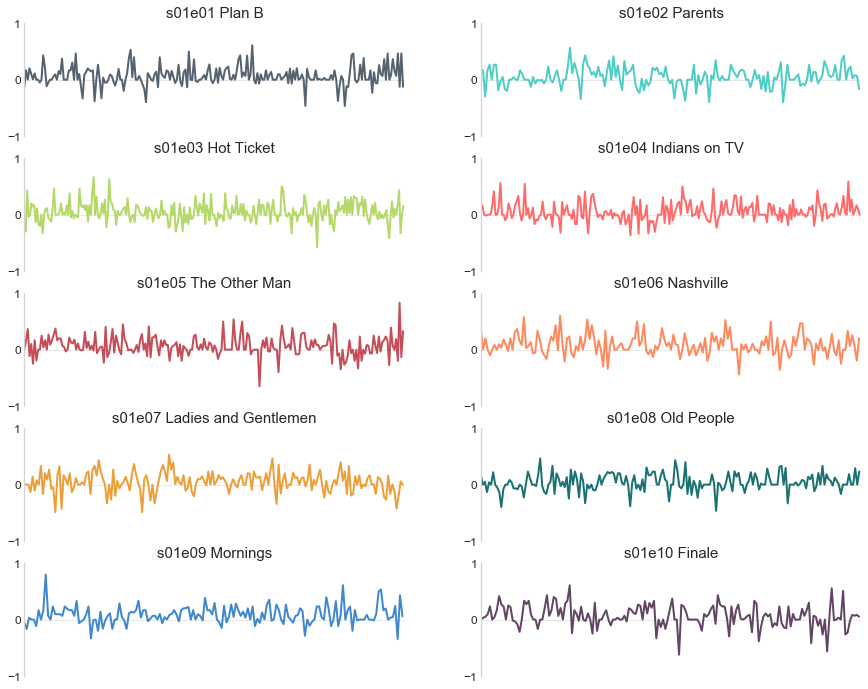

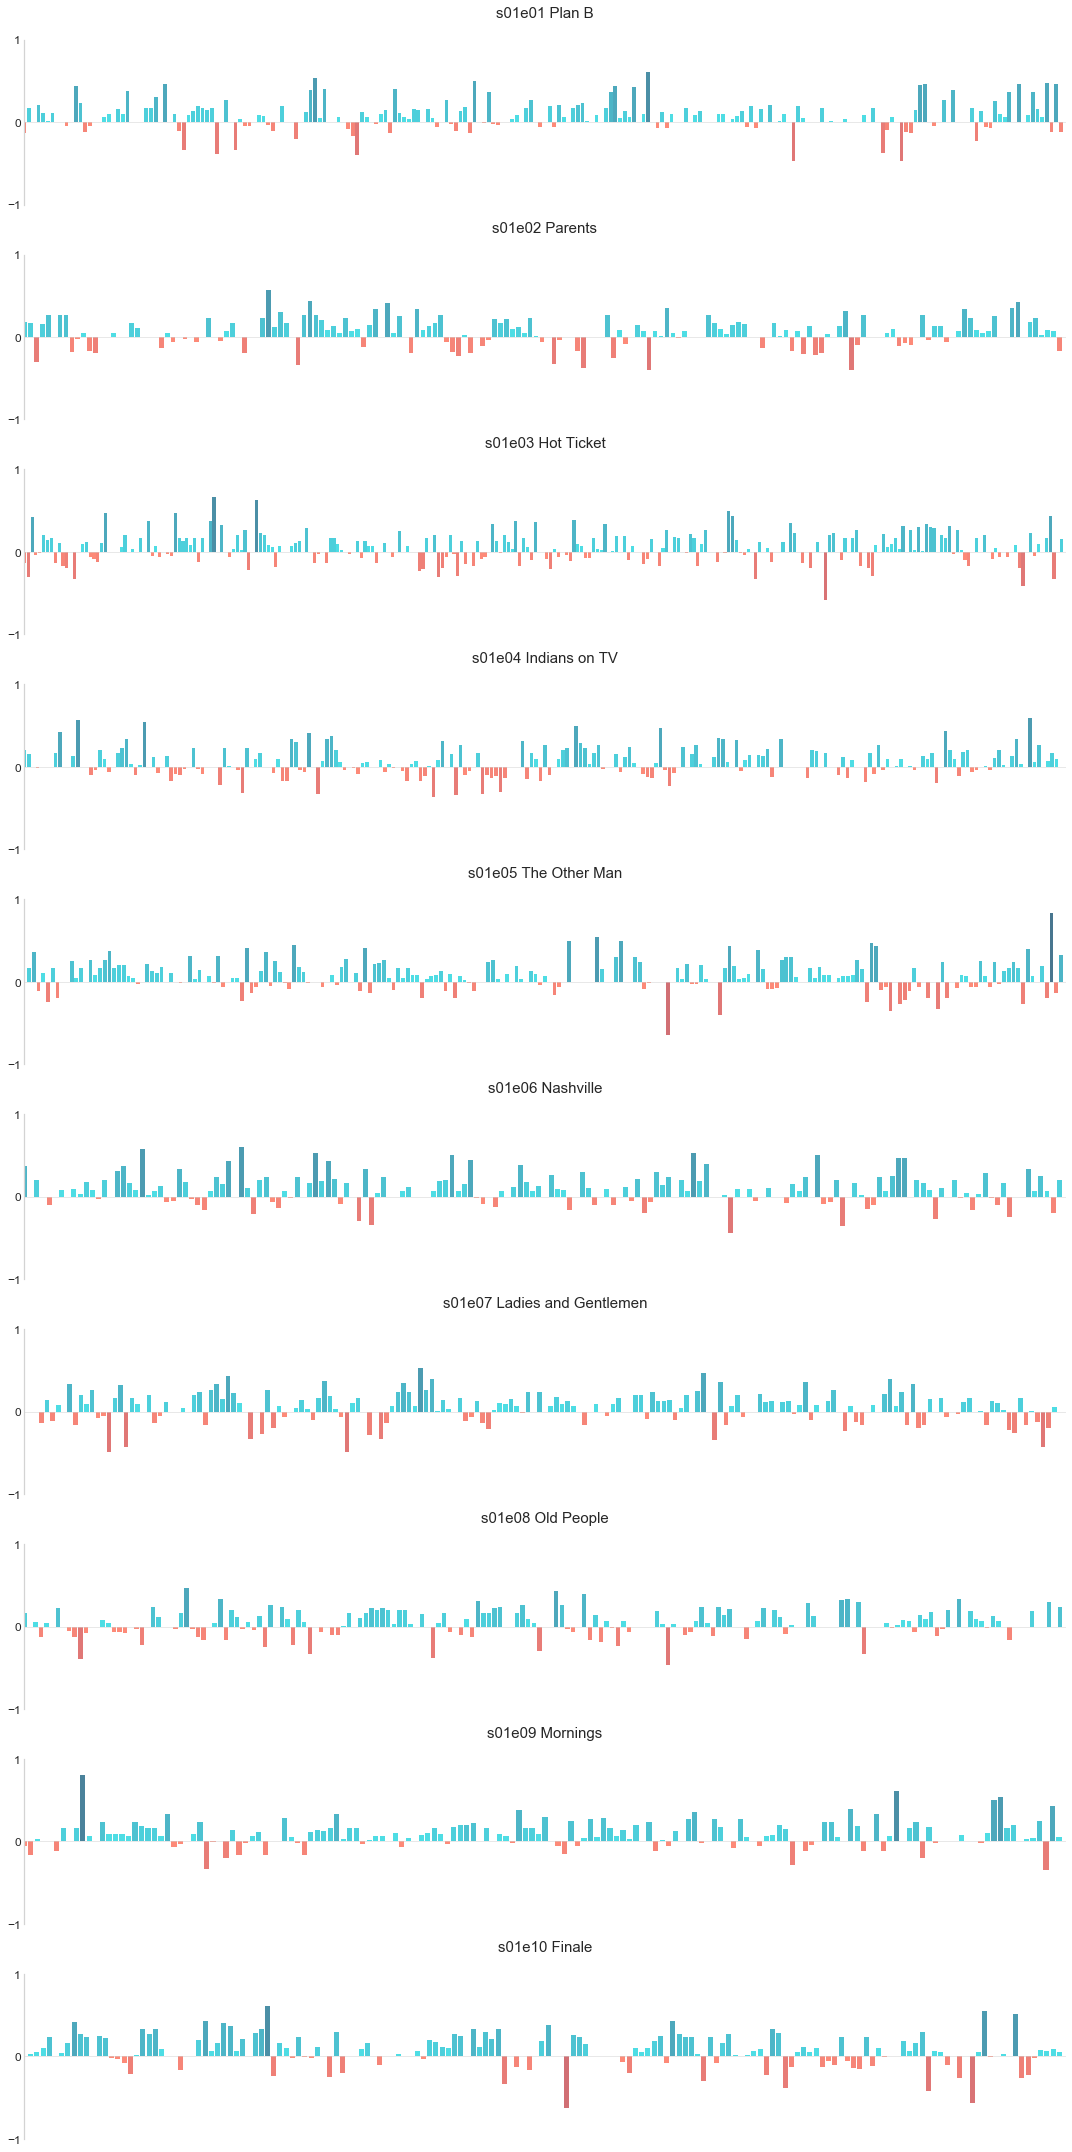

In [267]:
fig1, axes1 = plt.subplots(figsize=(15, 12), nrows=5, ncols=2)
fig2, axes2 = plt.subplots(figsize=(15, 30), nrows=10, ncols=1)
axes1 = axes1.reshape(-1)
axes2 = axes2.reshape(-1)

s1_episode_polarities = {}

# uncomment to write top sentences to file
# sentence_file = open('./Master-of-None-sentences.txt', 'w')

for i, (ax1, ax2, episode) in enumerate(zip(axes1, axes2, s1_episodes)):
    with open('{}/{}'.format(episode_dir, episode), 'r') as f:
        text = f.read()
        cleaned_text = clean_text(text)
        blob = TextBlob(cleaned_text)
        title = get_episode_title(episode, episode_info=True)
        
        episode_polarity = blob.sentiment.polarity
        s1_episode_polarities[title] = episode_polarity
        
        sentence_polarities = get_sentence_polarities(blob)
        sentence_df = create_sentence_df(sentence_polarities)
        averaged_polarities = average_over_window(sentence_df, 3)
        
        # line graph
        fig1, ax1 = create_plot(title='{}'.format(title), fig=fig1, ax=ax1, episode=True)
        ax1.plot(averaged_polarities['relative_position'], averaged_polarities['polarity'],
                color=colors[i], lw=2)
        ax1.set_xticklabels([])
        ax1.set_yticks([-1, 0, 1])

        # bar plot
        fig2, ax2 = create_plot(title='{}\n'.format(title), fig=fig2, ax=ax2, episode=True)
        
        sent_colors = pd.cut(averaged_polarities['polarity'], np.linspace(-1, 1, num=21, endpoint=True), 
                             include_lowest=True, labels=red_gradient + blue_gradient[::-1])
        
        ax2.bar(averaged_polarities['relative_position'], averaged_polarities['polarity'], 
               color=sent_colors, width=.8/len(averaged_polarities))
        ax2.set_xticklabels([])
        ax2.set_yticks([-1, 0, 1])
        
        # write_top_sentences(sentence_file, sentence_df, title)
        
# sentence_file.close()
        
plt.tight_layout() # fix overlapping text/labels     
plt.show()

### Season 1 Overall Episode Sentiment

The episodes, in order of most to least positive:

In [268]:
print("Episode|Polarity")
for ep in sorted(s1_episode_polarities, key=s1_episode_polarities.get, reverse=True):
    polarity = round(s1_episode_polarities[ep], 5)
    print('{}|{}'.format(ep, polarity))

Episode|Polarity
s01e01 Plan B|0.17624
s01e09 Mornings|0.17505
s01e06 Nashville|0.15706
s01e05 The Other Man|0.13835
s01e10 Finale|0.12934
s01e04 Indians on TV|0.11561
s01e03 Hot Ticket|0.1064
s01e07 Ladies and Gentlemen|0.10614
s01e02 Parents|0.10543
s01e08 Old People|0.10252


## Season 2

And similar analysis for season 2:

In [269]:
s2_episodes = get_season_episodes(episode_dir, 2)
s2_episodes = sorted(s2_episodes)

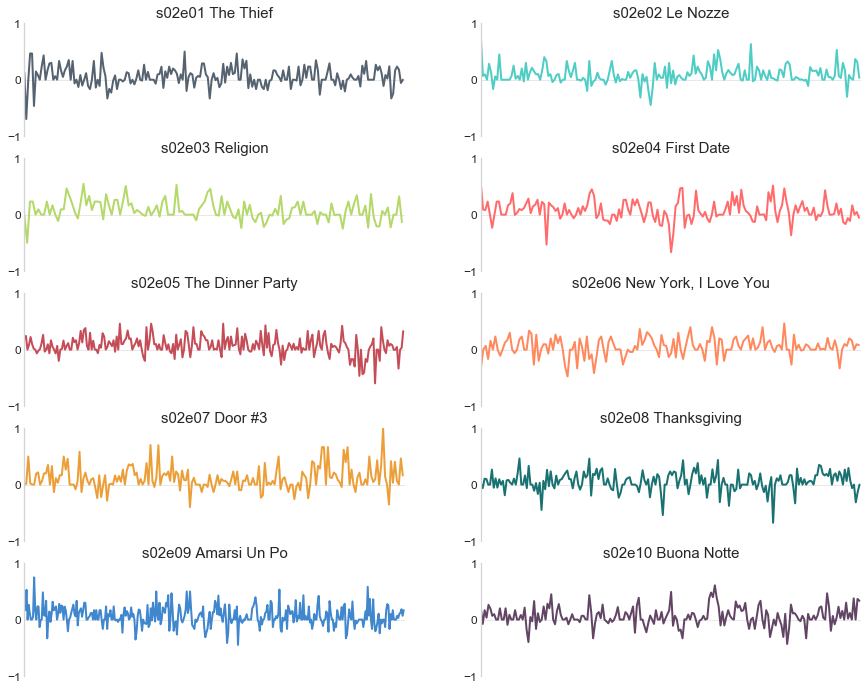

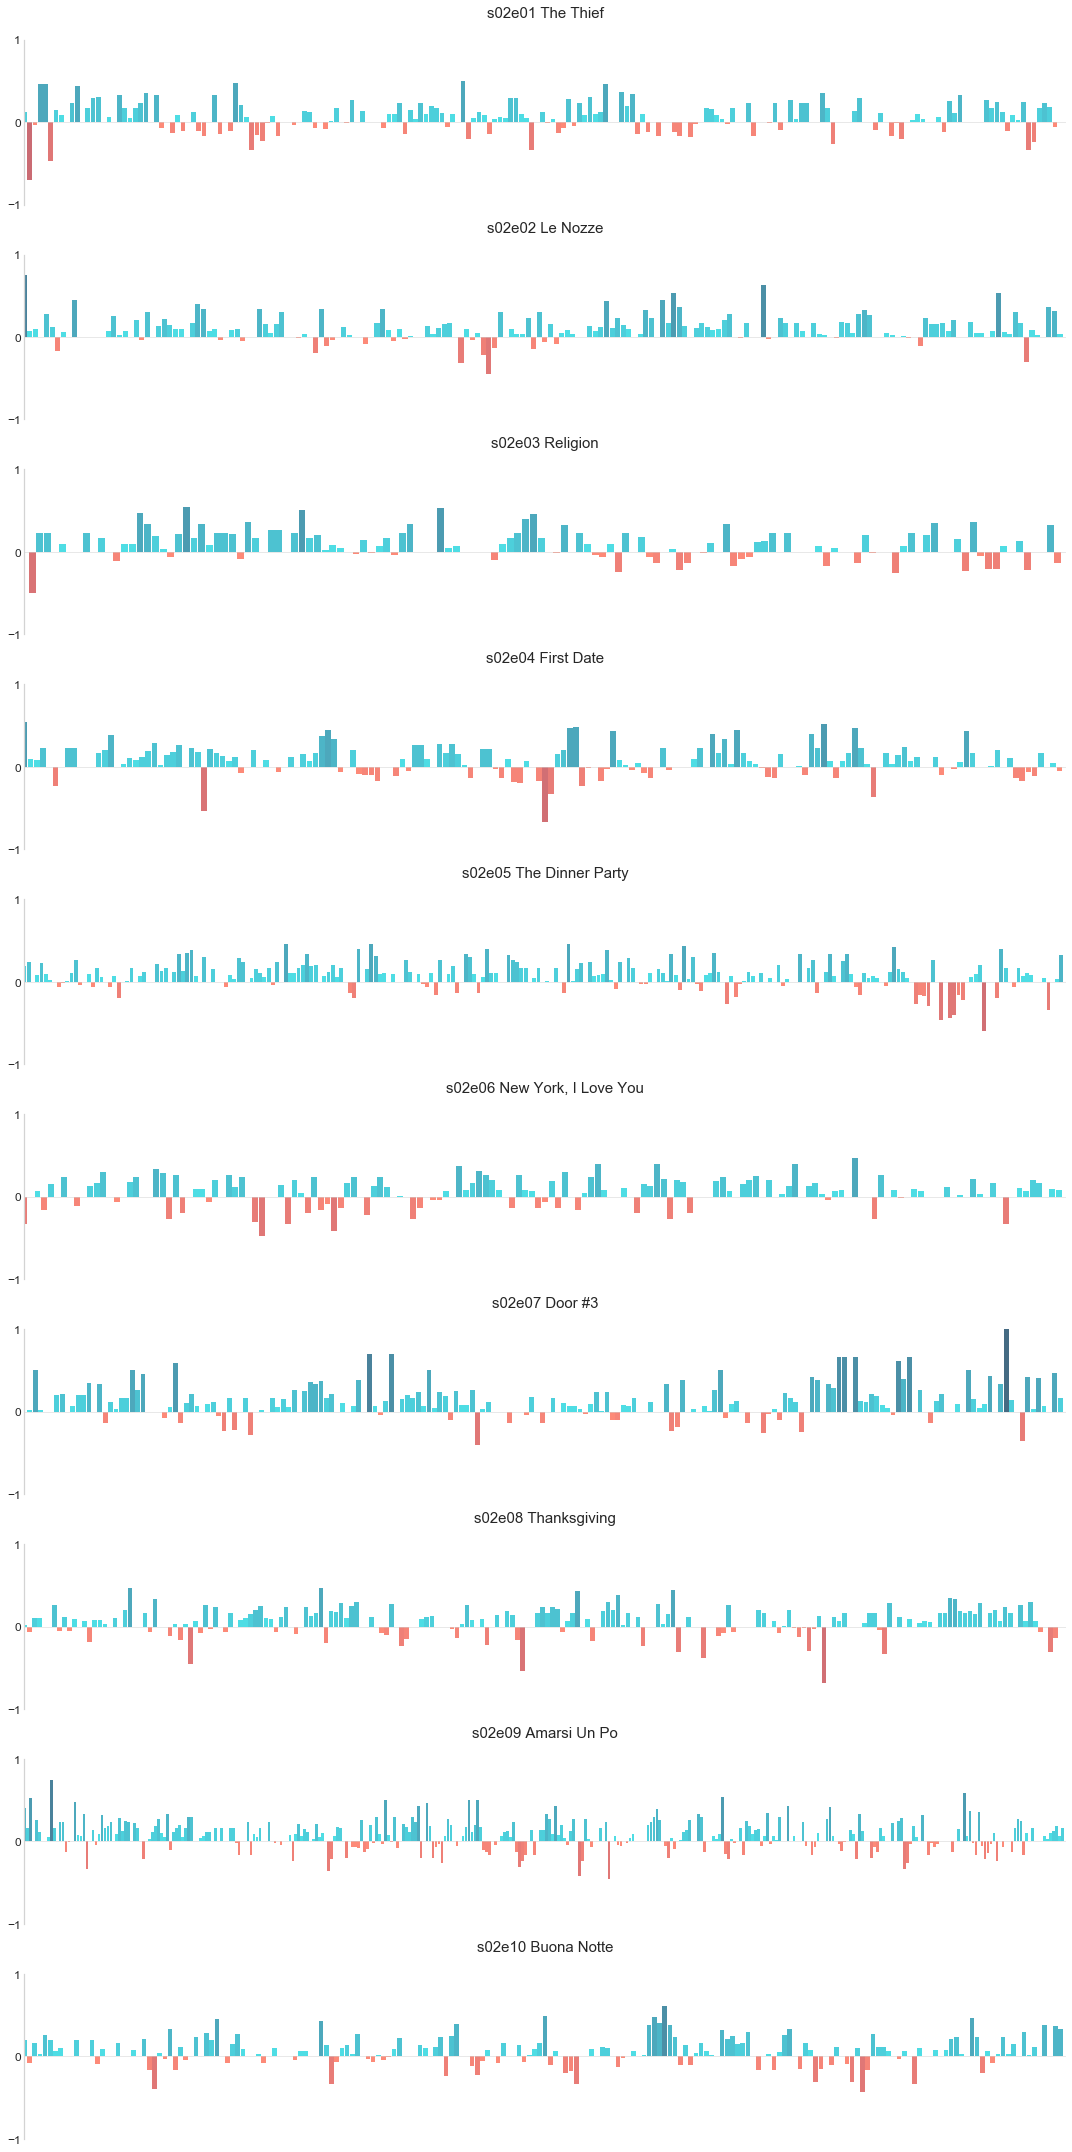

In [270]:
fig1, axes1 = plt.subplots(figsize=(15, 12), nrows=5, ncols=2)
fig2, axes2 = plt.subplots(figsize=(15, 30), nrows=10, ncols=1)
axes1 = axes1.reshape(-1)
axes2 = axes2.reshape(-1)

s2_episode_polarities = {}

# sentence_file = open('./Master-of-None-sentences.txt', 'a')

for i, (ax1, ax2, episode) in enumerate(zip(axes1, axes2, s2_episodes)):
    with open('{}/{}'.format(episode_dir, episode), 'r') as f:
        text = f.read()
        cleaned_text = clean_text(text)
        blob = TextBlob(cleaned_text)
        title = get_episode_title(episode, episode_info=True)
        
        episode_polarity = blob.sentiment.polarity
        s2_episode_polarities[title] = episode_polarity
        
        sentence_polarities = get_sentence_polarities(blob)
        sentence_df = create_sentence_df(sentence_polarities)
        averaged_polarities = average_over_window(sentence_df, 3)
        
        # line graph
        fig1, ax1 = create_plot(title='{}'.format(title), fig=fig1, ax=ax1, episode=True)
        ax1.plot(averaged_polarities['relative_position'], averaged_polarities['polarity'],
                color=colors[i], lw=2)
        ax1.set_xticklabels([])
        ax1.set_yticks([-1, 0, 1])

        # bar plot
        fig2, ax2 = create_plot(title='{}\n'.format(title), fig=fig2, ax=ax2, episode=True)
        
        sent_colors = pd.cut(averaged_polarities['polarity'], np.linspace(-1, 1, num=21, endpoint=True), 
                             include_lowest=True, labels=red_gradient + blue_gradient[::-1])
        
        ax2.bar(averaged_polarities['relative_position'], averaged_polarities['polarity'], 
               color=sent_colors, width=.9/len(averaged_polarities))
        ax2.set_xticklabels([])
        ax2.set_yticks([-1, 0, 1])
        
        # write_top_sentences(sentence_file, sentence_df, title)
        
# sentence_file.close()
        
plt.tight_layout() # fix overlapping text/labels     
plt.show()

Some notes:
- Analyzing dialogues doesn't take silence into account - and a lot can be conveyed in silence. For instance, episode 5 'The Dinner Party' ends with a silent & sobering long Uber ride home. Yet in the graph, 'The Dinner Party' ends on a positive note because the last dialogue in the episode are of Francesca and Dev saying good night.

### Season 2 Overall Episode Sentiment

The episodes, in order of most to least positive:

In [271]:
print("Episode|Polarity")
for ep in sorted(s2_episode_polarities, key=s2_episode_polarities.get, reverse=True):
    polarity = round(s2_episode_polarities[ep], 5)
    print('{}|{}'.format(ep, polarity))

Episode|Polarity
s02e07 Door #3|0.25798
s02e02 Le Nozze|0.19024
s02e03 Religion|0.17524
s02e05 The Dinner Party|0.17257
s02e09 Amarsi Un Po|0.16332
s02e04 First Date|0.15358
s02e01 The Thief|0.1338
s02e10 Buona Notte|0.13298
s02e06 New York, I Love You|0.13073
s02e08 Thanksgiving|0.12602


## Comparing Season 1 & Season 2

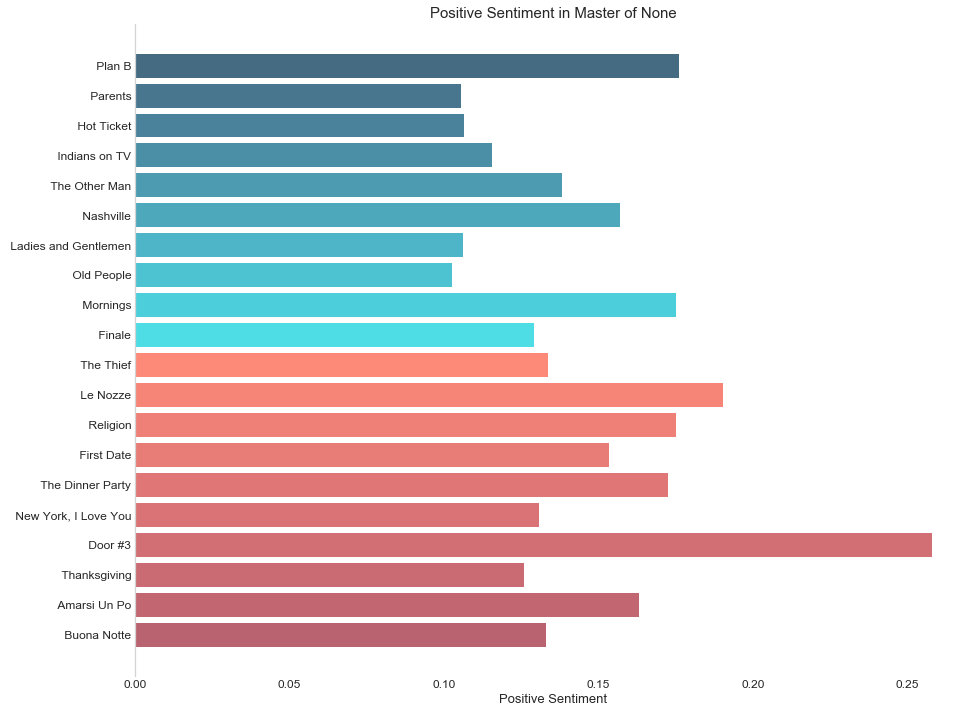

In [272]:
fig, ax = create_plot(figsize=(15, 12), title="Positive Sentiment in Master of None",
                      xlabel="Positive Sentiment")

s1_titles = list(s1_episode_polarities.keys())
s1_polarities = [s1_episode_polarities[title] for title in s1_titles]
s1_titles = [get_episode_title(title, episode_info=False) for title in s1_titles] # no ep info

s2_titles = list(s2_episode_polarities.keys())
s2_polarities = [s2_episode_polarities[title] for title in s2_titles]
s2_titles = [get_episode_title(title, episode_info=False) for title in s2_titles]

all_titles = s1_titles + s2_titles
all_height = s1_polarities + s2_polarities
season = [1 for _ in range(10)] + [2 for _ in range(10)]

all_colors = blue_gradient + red_gradient[::-1]

for title, height, color in zip(all_titles, all_height, all_colors):
    ax.barh(title, height, color=color)  
    
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
plt.gca().invert_yaxis()

plt.show()

Hmmm, looks like Season 2 is a 'lil more positive than Season 1 as a whole.

I'm just gonna end this with one of my favorite Aziz Ansari scenes / quotes of all time:

![Red Carpet Insole](http://iruntheinternet.com/lulzdump/images/aziz-ansari-red-carpet-insole-shoe-parks-and-recreation-red-carpet-1360763940f.png?id=)

## Visualizing Scenes Interactively

In [273]:
inline_display(line_chart1)

In [274]:
inline_display(line_chart2)

In [275]:
inline_display(line_chart3)